## top-R (擬似的実数版top-k)

In [232]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import itertools
from random import shuffle
import codecs

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
def factorial(n):
    if n == 0:
        return 1
    elif n > 0:
        return n*factorial(n - 1)
    else:
        print("sth wrong")

In [3]:
# top-k labelling
def topk_label(probas, s_cls, k):
    l_indexes = probas.argsort()[::-1][:k]
    labels = np.array([s_cls[i] for i in l_indexes])
    return labels

In [4]:
# labelling and evaluating them
def topk_scls_eval(part, classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]
    tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] in s_cls]
    tst_labels = [label for label in test_labels if label in s_cls]

    # generate an annotator
    ann_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    
    # for top-1.0
    if (part == 0):
        mul_labels = ann_model.predict(trn_imgs[orig_A:orig_A + lim_A])
        # labels score evaluation
        score = 0
        for label, t_label in zip(mul_labels, trn_labels[orig_A:orig_A + lim_A]):
            if (label == t_label):
                score += 1
        
        return (1.0, score*100/len(mul_labels), score*100/lim_A)
    
    # for top-R (1.05, 1.1, ..., 1.25)
    else:
        # split data to label into two groups
        f_imgs, s_imgs, f_labels, s_labels = train_test_split(trn_imgs[orig_A:orig_A + lim_A], trn_labels[orig_A:orig_A + lim_A], test_size = part/100)
        # top-1
        f_ann_proba = ann_model.predict_proba(f_imgs)
        ord_labels = [topk_label(probas, s_cls, 1) for probas in f_ann_proba]
        # top-2
        s_ann_proba = ann_model.predict_proba(s_imgs)
        top2_labels = [topk_label(probas, s_cls, 2) for probas in s_ann_proba]
        # concat top-1 results and top-2 results
        mul_labels = ord_labels + top2_labels
        
        # labels score evaluation
        score = 0
        for labels, t_label in zip(mul_labels, f_labels + s_labels):
            for l in labels:
                if (l == t_label):
                    score += 1

        m_labels = []
        for labels in mul_labels:
             [m_labels.append(l) for l in labels]                
                    
        return (len(m_labels)/lim_A, score*100/len(m_labels), score*100/lim_A)

In [6]:
# loading MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])
img_SIZE = train_images.shape[1]*train_images.shape[2]

### Rは1.00-1.25を0.05刻みで

In [7]:
Rs = [i/100 for i in range(100, 130, 5)]
for R in Rs:
    print (f"top-{R}; {round((R - 1.00)*100)}% of data mul-labelled")

top-1.0; 0% of data mul-labelled
top-1.05; 5% of data mul-labelled
top-1.1; 10% of data mul-labelled
top-1.15; 15% of data mul-labelled
top-1.2; 20% of data mul-labelled
top-1.25; 25% of data mul-labelled


### さしあたりtop-1とtop-2の組み合わせで実装(25/02/2020)

In [8]:
# main experiment
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)

In [9]:
# main experiment
Rs = [i/100 for i in range(100, 130, 5)]
for R in Rs:
    mnist_evals = []
    part = round((R - 1.00)*100)
    for i in range(2, 11): # i: num of sub-classes
        print(f"{i} classes, top-{R}, {part}% of data mul-labelled")
        combi_ni = fact_10//(factorial(i)*factorial(10 - i))
        a, b, c = 0, 0, 0
        
        if (i == 10):
            a, b, c = 0, 0, 0
            for _ in range(5):
                d, e, f = topk_scls_eval(part, [a for a in range(10)], orig_A1, lim_A1)
                a += d
                b += e
                c += f
            sample_lnum, sample_lqual, sample_lqual2 = a/5, b/5, c/5 
            mnist_evals.append((sample_lnum, sample_lqual, sample_lqual2))
        else:
            continue
#             for scls in itertools.combinations(classes, i):
#                 x, y, z = 0, 0, 0
#                 for _ in range(5):
#                     s, t, u = topk_scls_eval(part, list(scls), orig_A1, lim_A1)
#                     x += s
#                     y += t
#                     z += u
#                 sample_lnum, sample_lqual, sample_lqual2 = x/5, y/5, z/5
#                 a += sample_lnum
#                 b += sample_lqual
#                 c += sample_lqual2
#             mnist_evals.append((a/combi_ni, b/combi_ni, c/combi_ni))
    print(mnist_evals)

2 classes, top-1.0, 0% of data mul-labelled
3 classes, top-1.0, 0% of data mul-labelled
4 classes, top-1.0, 0% of data mul-labelled
5 classes, top-1.0, 0% of data mul-labelled
6 classes, top-1.0, 0% of data mul-labelled
7 classes, top-1.0, 0% of data mul-labelled
8 classes, top-1.0, 0% of data mul-labelled
9 classes, top-1.0, 0% of data mul-labelled
10 classes, top-1.0, 0% of data mul-labelled
[(1.0, 84.8, 84.8)]
2 classes, top-1.05, 5% of data mul-labelled
3 classes, top-1.05, 5% of data mul-labelled
4 classes, top-1.05, 5% of data mul-labelled
5 classes, top-1.05, 5% of data mul-labelled
6 classes, top-1.05, 5% of data mul-labelled
7 classes, top-1.05, 5% of data mul-labelled
8 classes, top-1.05, 5% of data mul-labelled
9 classes, top-1.05, 5% of data mul-labelled
10 classes, top-1.05, 5% of data mul-labelled
[(1.05, 81.13333333333333, 85.19)]
2 classes, top-1.1, 10% of data mul-labelled
3 classes, top-1.1, 10% of data mul-labelled
4 classes, top-1.1, 10% of data mul-labelled
5 class

### グラフ用

In [233]:
R1 = [(1.0, 97.91555555555556, 97.91555555555556), (1.0, 95.70125000000003, 95.70125000000003), (1.0, 93.45761904761905, 93.45761904761905), (1.0, 91.62242063492069, 91.62242063492069), (1.0, 90.20309523809519, 90.20309523809519), (1.0, 88.35958333333333, 88.35958333333333), (1.0, 86.63111111111112, 86.63111111111112), (1.0, 85.8, 85.8), (1.0, 84.8, 84.8)]
# R105 = [(1.0499999999999994, 93.34835978835979, 98.01577777777779), (1.049999999999998, 91.30658730158731, 95.87191666666669), (1.0500000000000036, 89.22530612244897, 93.68657142857147), (1.050000000000005, 87.51383219954643, 91.8895238095238), (1.0500000000000036, 86.1877097505669, 90.49709523809518), (1.049999999999998, 84.44865079365081, 88.6710833333333), (1.0499999999999994, 82.84994708994708, 86.99244444444446), (1.0500000000000003, 82.10857142857142, 86.214), (1.05, 81.13333333333333, 85.19)]
# R110 = [(1.1000000000000008, 89.20101010101007, 98.1211111111111), (1.0999999999999976, 87.31242424242423, 96.04366666666668), (1.0999999999999963, 85.38346320346325, 93.92180952380946), (1.099999999999998, 83.78903318903325, 92.16793650793647), (1.0999999999999963, 82.53064935064936, 90.78371428571428), (1.0999999999999976, 80.89939393939393, 88.98933333333338), (1.1000000000000008, 79.40929292929293, 87.3502222222222), (1.0999999999999999, 78.67272727272727, 86.53999999999999), (1.1, 77.84545454545454, 85.63000000000001)]
# R115 = [(1.149999999999999, 85.41951690821254, 98.23244444444444), (1.1500000000000026, 83.66934782608698, 96.21975000000002), (1.150000000000004, 81.86521739130433, 94.14499999999998), (1.150000000000001, 80.37705314009659, 92.43361111111109), (1.150000000000004, 79.20041407867494, 91.08047619047616), (1.1500000000000026, 77.64594202898549, 89.29283333333335), (1.149999999999999, 76.27497584541062, 87.71622222222219), (1.1500000000000001, 75.57217391304349, 86.90800000000002), (1.15, 74.71304347826087, 85.92)]
R120 = [(1.2000000000000008, 81.95703703703701, 98.34844444444447), (1.2000000000000004, 80.33027777777777, 96.3963333333333), (1.1999999999999953, 78.64257936507943, 94.37109523809531), (1.1999999999999942, 77.2594907407407, 92.71138888888883), (1.1999999999999953, 76.14583333333331, 91.37499999999999), (1.2000000000000004, 74.68027777777779, 89.61633333333333), (1.2000000000000008, 73.39537037037039, 88.07444444444442), (1.1999999999999997, 72.7525, 87.30300000000001), (1.2, 71.96666666666667, 86.36000000000001)]
# R125 = [(1.25, 78.75413333333333, 98.44266666666668), (1.25, 77.2498, 96.56225), (1.25, 75.68685714285712, 94.60857142857144), (1.25, 74.3832698412699, 92.97908730158727), (1.25, 73.3336, 91.66699999999996), (1.25, 71.93293333333334, 89.91616666666661), (1.25, 70.75946666666665, 88.44933333333334), (1.25, 70.0904, 87.61300000000001), (1.25, 69.312, 86.64)]
R140 = [(1.4, 62.7), (1.4, 62.91428571428571), (1.4, 62.93571428571429), (1.4, 62.857142857142854), (1.4, 62.74285714285713), (1.4, 62.86428571428572), (1.4, 63.01428571428571), (1.4, 63.10714285714287), (1.4, 62.93571428571429)]
R160 = [(1.6, 56.15625), (1.6, 56.0625), (1.6, 56.19375), (1.6, 55.89375), (1.6, 56.03125), (1.6, 55.9875), (1.6, 56.0875), (1.6, 56.0875), (1.6, 56.03125)]
R180 = [(1.8, 50.68888888888889), (1.8, 50.66111111111111), (1.8, 50.68888888888888), (1.8, 50.772222222222226), (1.8, 50.68333333333333), (1.8, 50.73888888888889), (1.8, 50.638888888888886), (1.8, 50.63888888888889), (1.8, 50.738888888888894)]

In [234]:
results_list = [R1, R120, R140, R160, R180]

In [235]:
lqual_10cls = [results_list[i][8][1] for i in range(5)]
lqual_10cls.extend([49.57270833333334, 33.128650793650806, 24.887500000000006, 19.934380952380938, 16.60902777777778, 14.243968253968252, 12.463125, 11.094444444444445])

In [220]:
q_neginf_lnum = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
neg_one_lnum = [e[0] for e in [(1.0, 97.91555555555556, 97.91555555555556), (1.3845124999999996, 71.38385625432825, 98.55541666666664), (1.8689428571428577, 52.91222129091504, 98.51904761904763), (2.41676388888889, 40.890537972190884, 98.56091269841268), (2.982421428571428, 33.10343690579796, 98.5540476190476), (3.556491666666666, 27.671551255241464, 98.29833333333335), (4.181222222222221, 23.496303659557906, 98.20222222222223), (4.7951999999999995, 20.54094298636682, 98.465), (5.3105, 18.58582054420488, 98.7)]]
neg_qtenth_lnum = [e[0] for e in [(1.0, 97.91555555555556, 97.91555555555556), (1.0613500000000002, 91.72974138980769, 97.26083333333334), (1.1240714285714286, 85.77158372470802, 96.25571428571422), (1.1868948412698417, 80.53765799421383, 95.41746031746032), (1.2382238095238092, 76.59990800478742, 94.69571428571426), (1.3047375000000008, 71.76414476419197, 93.51833333333329), (1.363288888888889, 68.1265165947613, 92.81111111111113), (1.4243000000000001, 65.02584678961306, 92.59), (1.464, 62.90983606557377, 92.1)]]
qzero_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0334791666666665, 93.6843518370719, 96.76875000000001), (1.0668666666666662, 89.47267758364897, 95.36976190476183), (1.09899603174603, 85.8062582442501, 94.20972222222221), (1.1204880952380947, 83.1971582554879, 93.14333333333335), (1.1499875000000002, 79.74666930534073, 91.64916666666667), (1.1786222222222222, 76.93905685280227, 90.64999999999998), (1.2072499999999997, 74.74123905374579, 90.22), (1.224, 73.24346405228758, 89.65)]]
qtenth_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0153624999999995, 94.85813232195665, 96.28750000000001), (1.040192857142857, 91.17737449617876, 94.78523809523807), (1.0631765873015873, 88.0097438324857, 93.50714285714292), (1.078071428571429, 85.68343541307117, 92.31785714285716), (1.0971541666666669, 82.77710753888428, 90.78208333333332), (1.1163999999999996, 80.28869810847034, 89.61444444444443), (1.1384, 78.31796205282639, 89.15), (1.153, 76.71292281006072, 88.45)]]
qhalf_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.000829166666667, 95.65711936176007, 95.73416666666675), (1.00932619047619, 92.99069821528626, 93.84071428571428), (1.0211329365079373, 90.51513899763995, 92.4017857142857), (1.0303785714285714, 88.5260226380746, 91.18857142857144), (1.0412875000000008, 86.02027569573764, 89.55208333333334), (1.0522666666666665, 83.88761737437736, 88.26333333333336), (1.0673, 82.19186677383794, 87.72000000000001), (1.0715, 80.86794213719085, 86.65)]]
qshannon_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0002666666666673, 95.68549599721796, 95.71041666666675), (1.0038880952380944
, 93.26399325942879, 93.61928571428577), (1.0108154761904755, 91.04578412095299, 92.0160714285714), (1.0168833333333336, 89.25887661366012, 
90.74976190476191), (1.0251500000000002, 86.91056740481199, 89.08374999999998), (1.0323444444444445, 84.92817190015958, 87.6688888888889), (
1.04225, 83.53148915619434, 87.05499999999999), (1.051, 82.20742150333017, 86.4)]]
# q2_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.000145833333334, 95.69390536534902, 95.70750000000007), (1.0027000000000004, 93.32589589872764, 93.57238095238102), (1.0079464285714281, 91.19911103693669, 91.91250000000001), (1.0126523809523802, 89.49826752257391, 90.61785714285712), (1.0195166666666664, 87.22926874979792, 88.92166666666664), (1.0256222222222224, 85.28469966288097, 87.46444444444444), (1.03315, 84.06680236236342, 86.85000000000001), (1.0425, 82.54196642685851, 86.05)]]
# q10_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0000791666666669, 95.6972572093726, 95.7045833333334), (1.001816666666666, 93.3721980271965, 93.53785714285718), (1.0055555555555549, 91.32998825165733, 91.82837301587303), (1.008983333333333, 89.70908372946477, 90.50523809523814), (1.0142625, 87.53556894037482, 88.775), (1.0189111111111109, 85.65135997826238, 87.26555555555554), (1.02585, 84.45058240098153, 86.63000000000001), (1.0315, 83.08288899660688, 85.7)]]
qtop1_lnum = [e[0] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0, 95.70083333333339, 95.70083333333339), (1.0, 93.45857142857146, 93.45857142857146), (1.0, 91.61924603174603, 91.61924603174603), (1.0, 90.20047619047618, 90.20047619047618), (1.0, 88.34375000000001, 88.34375000000001), (1.0, 86.64555555555555, 86.64555555555555), (1.0, 85.785, 85.785), (1.0, 84.8, 84.8)]]

In [222]:
qlnum = [q_neginf_lnum, neg_one_lnum, neg_qtenth_lnum, qzero_lnum, qtenth_lnum, qhalf_lnum, qshannon_lnum, qtop1_lnum]

In [223]:
q_neg_inf = [97.91555555555557, 49.57270833333334, 33.128650793650806, 24.887500000000006, 19.934380952380938, 16.60902777777778, 14.243968253968252, 12.463125, 11.094444444444445]
neg_one = [e[1] for e in [(1.0, 97.91555555555556, 97.91555555555556), (1.3845124999999996, 71.38385625432825, 98.55541666666664), (1.8689428571428577, 52.91222129091504, 98.51904761904763), (2.41676388888889, 40.890537972190884, 98.56091269841268), (2.982421428571428, 33.10343690579796, 98.5540476190476), (3.556491666666666, 27.671551255241464, 98.29833333333335), (4.181222222222221, 23.496303659557906, 98.20222222222223), (4.7951999999999995, 20.54094298636682, 98.465), (5.3105, 18.58582054420488, 98.7)]]
neg_qtenth = [e[1] for e in [(1.0, 97.91555555555556, 97.91555555555556), (1.0613500000000002, 91.72974138980769, 97.26083333333334), (1.1240714285714286, 85.77158372470802, 96.25571428571422), (1.1868948412698417, 80.53765799421383, 95.41746031746032), (1.2382238095238092, 76.59990800478742, 94.69571428571426), (1.3047375000000008, 71.76414476419197, 93.51833333333329), (1.363288888888889, 68.1265165947613, 92.81111111111113), (1.4243000000000001, 65.02584678961306, 92.59), (1.464, 62.90983606557377, 92.1)]]
qzero = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0334791666666665, 93.6843518370719, 96.76875000000001), (1.0668666666666662, 89.47267758364897, 95.36976190476183), (1.09899603174603, 85.8062582442501, 94.20972222222221), (1.1204880952380947, 83.1971582554879, 93.14333333333335), (1.1499875000000002, 79.74666930534073, 91.64916666666667), (1.1786222222222222, 76.93905685280227, 90.64999999999998), (1.2072499999999997, 74.74123905374579, 90.22), (1.224, 73.24346405228758, 89.65)]]
qtenth = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0153624999999995, 94.85813232195665, 96.28750000000001), (1.040192857142857, 91.17737449617876, 94.78523809523807), (1.0631765873015873, 88.0097438324857, 93.50714285714292), (1.078071428571429, 85.68343541307117, 92.31785714285716), (1.0971541666666669, 82.77710753888428, 90.78208333333332), (1.1163999999999996, 80.28869810847034, 89.61444444444443), (1.1384, 78.31796205282639, 89.15), (1.153, 76.71292281006072, 88.45)]]
qhalf = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.000829166666667, 95.65711936176007, 95.73416666666675), (1.00932619047619, 92.99069821528626, 93.84071428571428), (1.0211329365079373, 90.51513899763995, 92.4017857142857), (1.0303785714285714, 88.5260226380746, 91.18857142857144), (1.0412875000000008, 86.02027569573764, 89.55208333333334), (1.0522666666666665, 83.88761737437736, 88.26333333333336), (1.0673, 82.19186677383794, 87.72000000000001), (1.0715, 80.86794213719085, 86.65)]]
qshannon = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0002666666666673, 95.68549599721796, 95.71041666666675), (1.0038880952380944
, 93.26399325942879, 93.61928571428577), (1.0108154761904755, 91.04578412095299, 92.0160714285714), (1.0168833333333336, 89.25887661366012, 
90.74976190476191), (1.0251500000000002, 86.91056740481199, 89.08374999999998), (1.0323444444444445, 84.92817190015958, 87.6688888888889), (
1.04225, 83.53148915619434, 87.05499999999999), (1.051, 82.20742150333017, 86.4)]]
# q2 = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.000145833333334, 95.69390536534902, 95.70750000000007), (1.0027000000000004, 93.32589589872764, 93.57238095238102), (1.0079464285714281, 91.19911103693669, 91.91250000000001), (1.0126523809523802, 89.49826752257391, 90.61785714285712), (1.0195166666666664, 87.22926874979792, 88.92166666666664), (1.0256222222222224, 85.28469966288097, 87.46444444444444), (1.03315, 84.06680236236342, 86.85000000000001), (1.0425, 82.54196642685851, 86.05)]]
# q10 = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0000791666666669, 95.6972572093726, 95.7045833333334), (1.001816666666666, 93.3721980271965, 93.53785714285718), (1.0055555555555549, 91.32998825165733, 91.82837301587303), (1.008983333333333, 89.70908372946477, 90.50523809523814), (1.0142625, 87.53556894037482, 88.775), (1.0189111111111109, 85.65135997826238, 87.26555555555554), (1.02585, 84.45058240098153, 86.63000000000001), (1.0315, 83.08288899660688, 85.7)]]
qtop1 = [e[1] for e in [(1.0, 97.91555555555557, 97.91555555555557), (1.0, 95.70083333333339, 95.70083333333339), (1.0, 93.45857142857146, 93.45857142857146), (1.0, 91.61924603174603, 91.61924603174603), (1.0, 90.20047619047618, 90.20047619047618), (1.0, 88.34375000000001, 88.34375000000001), (1.0, 86.64555555555555, 86.64555555555555), (1.0, 85.785, 85.785), (1.0, 84.8, 84.8)]]

In [224]:
qqual = [q_neg_inf, neg_one, neg_qtenth, qzero, qtenth, qhalf, qshannon, qtop1]

In [228]:
print([line[8] for line in qqual])
print([line[8] for line in qlnum])

[11.094444444444445, 18.58582054420488, 62.90983606557377, 73.24346405228758, 76.71292281006072, 80.86794213719085, 82.20742150333017, 84.8]
[9.0, 5.3105, 1.464, 1.224, 1.153, 1.0715, 1.051, 1.0]


In [236]:
tsallis_10cls = [11.094444444444445, 18.58582054420488, 28.844444444444445, 62.90983606557377, 73.24346405228758, 76.71292281006072, 80.86794213719085, 82.20742150333017, 84.8]
tsallis_10cls_lnumave = [9.0, 5.3105, 3.375, 1.464, 1.224, 1.153, 1.0715, 1.051, 1.0]

In [237]:
def graph_it1(lqual_ncls, tsallis_ncls_lnumave, tsallis_ncls, cls_num):
    file_name = "tsallis_vs_top-R_{}cls_mnist.pdf".format(cls_num)
    fig = plt.figure(dpi = 100)
    ax = fig.add_subplot(111)
    pos = [i + 1 for i in range(10)] 
    ticks = [str(e) for e in pos]
    ax.set_xscale('log')
    ax.set_xticks(pos)
    ax.set_xticklabels(ticks)
    Rs = [1.0, 1.2, 1.4, 1.6, 1.8]
    Rs.extend([i for i in range(2, 10)])

    plt.plot(Rs, lqual_ncls, marker = 'o', color = 'r', label = "Top-k")
    plt.plot(tsallis_ncls_lnumave[::-1], tsallis_ncls[::-1], marker = 'o', color = 'b', label = "Tsallis")

    plt.xlabel("Average Number of Generated Labels per Instance")
    plt.ylabel("Accuracy of Generated Labels [%]")

    plt.legend(loc = 'best')
    plt.grid(True)
    if (cls_num == 10):
        plt.savefig(file_name)

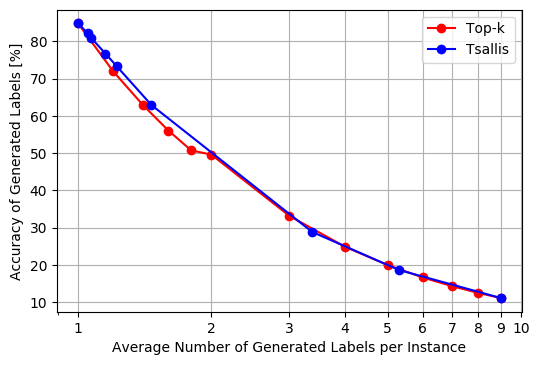

In [238]:
graph_it1(lqual_10cls, tsallis_10cls_lnumave, tsallis_10cls, 10)

In [250]:
lqual_10cls

[84.8,
 71.96666666666667,
 62.93571428571429,
 56.03125,
 50.738888888888894,
 49.57270833333334,
 33.128650793650806,
 24.887500000000006,
 19.934380952380938,
 16.60902777777778,
 14.243968253968252,
 12.463125,
 11.094444444444445]

In [ ]:
# for i in range(9):
#     lqual = [results_list[j][i][1] for j in range(6)]
#     tsallis_lnumave = [e[i] for e in qlnum]
#     tsallis = [e[i] for e in qqual]
#     graph_it(lqual, tsallis_lnumave, tsallis, i + 2)

# fashion MNIST

In [239]:
def graph_it2(lqual_ncls, tsallis_ncls_lnumave, tsallis_ncls, cls_num):
    file_name = "tsallis_vs_top-R_{}cls_fmnist.pdf".format(cls_num)
    fig = plt.figure(dpi = 100)
    ax = fig.add_subplot(111)
    pos = [i + 1 for i in range(10)] 
    ticks = [str(e) for e in pos]
    ax.set_xscale('log')
    ax.set_xticks(pos)
    ax.set_xticklabels(ticks)
    Rs = [1.0, 1.2, 1.4, 1.6, 1.8]
    Rs.extend([i for i in range(2, 10)])

    plt.plot(Rs, lqual_ncls, marker = 'o', color = 'r', label = "Top-k")
    plt.plot(tsallis_ncls_lnumave[::-1], tsallis_ncls[::-1], marker = 'o', color = 'b', label = "Tsallis")

    plt.xlabel("Average Number of Generated Labels per Instance")
    plt.ylabel("Accuracy of Generated Labels [%]")

    plt.legend(loc = 'best')
    plt.grid(True)
    if (cls_num == 10):
        plt.savefig(file_name)

In [240]:
R1_fm = [(1.0, 96.24222222222224, 96.24222222222224), (1.0, 93.00541666666668, 93.00541666666668), (1.0, 89.38952380952377, 89.38952380952377), (1.0, 86.88948412698414, 86.88948412698414), (1.0, 84.64904761904764, 84.64904761904764), (1.0, 82.24500000000003, 82.24500000000003), (1.0, 80.71444444444445, 80.71444444444445), (1.0, 77.38000000000001, 77.38000000000001), (1.0, 74.45, 74.45)]
# R105_fm = [(1.0499999999999994, 91.8283597883598, 96.41977777777781), (1.049999999999998, 88.8316666666667, 93.27325), (1.0500000000000036, 85.49414965986391, 89.76885714285712), (1.050000000000005, 83.1667044595616, 87.32503968253963), (1.0500000000000036, 81.087120181406, 85.14147619047623), (1.049999999999998, 78.85087301587302, 82.79341666666669), (1.0499999999999994, 77.40825396825394, 81.27866666666665), (1.0500000000000003, 74.28666666666666, 78.001), (1.05, 71.33333333333334, 74.9)]
# R110_fm = [(1.1000000000000008, 87.83898989898992, 96.62288888888888), (1.0999999999999976, 85.03090909090909, 93.53399999999995), (1.0999999999999963, 81.94852813852815, 90.14338095238097), (1.099999999999998, 79.80591630591636, 87.78650793650795), (1.0999999999999963, 77.85437229437235, 85.6398095238095), (1.0999999999999976, 75.76477272727274, 83.34124999999996), (1.1000000000000008, 74.4159595959596, 81.85755555555555), (1.0999999999999999, 71.47818181818182, 78.62599999999999), (1.1, 68.96363636363637, 75.86000000000001)]
# R115_fm = [(1.149999999999999, 84.17487922705314, 96.8011111111111), (1.1500000000000026, 81.57956521739129, 93.8165), (1.150000000000004, 78.72463768115946, 90.53333333333333), (1.150000000000001, 76.72253278122848, 88.23091269841272), (1.150000000000004, 74.891966873706, 86.1257619047619), (1.1500000000000026, 72.95217391304351, 83.89499999999998), (1.149999999999999, 71.70357487922705, 82.45911111111111), (1.1500000000000001, 68.94956521739132, 79.292), (1.15, 66.3391304347826, 76.28999999999999)]
R120_fm = [(1.2000000000000008, 80.83111111111111, 96.99733333333333), (1.2000000000000004, 78.40173611111113, 94.08208333333333), (1.1999999999999953, 75.74361111111111, 90.89233333333326), (1.1999999999999942, 73.89877645502641, 88.67853174603172), (1.1999999999999953, 72.20246031746032, 86.64295238095237), (1.2000000000000004, 70.36597222222221, 84.4391666666667), (1.2000000000000008, 69.17981481481482, 83.01577777777779), (1.1999999999999997, 66.66583333333332, 79.999), (1.2, 64.38333333333334, 77.26)]
# R125_fm = [(1.25, 77.74631111111111, 97.18288888888888), (1.25, 75.47080000000001, 94.3385), (1.25, 73.02175238095236, 91.27719047619048), (1.25, 71.29844444444447, 89.12305555555554), (1.25, 69.7122666666667, 87.14033333333332), (1.25, 68.00146666666667, 85.00183333333332), (1.25, 66.87768888888887, 83.5971111111111), (1.25, 64.4648, 80.58100000000002), (1.25, 62.176, 77.72)]
R140_fm = [(1.4, 56.93571428571429), (1.4, 56.87142857142857), (1.4, 56.77142857142858), (1.4, 57.135714285714286), (1.4, 56.86428571428572), (1.4, 56.73571428571428), (1.4, 56.864285714285714), (1.4, 56.82857142857142), (1.4, 56.921428571428564)]
R160_fm = [(1.6, 51.55625), (1.6, 51.45), (1.6, 51.33125), (1.6, 51.39375), (1.6, 51.525), (1.6, 51.33125), (1.6, 51.4375), (1.6, 51.38125), (1.6, 51.525)]
R180_fm = [(1.8, 47.30555555555556), (1.8, 47.01111111111111), (1.8, 47.111111111111114), (1.8, 47.038888888888884), (1.8, 47.2), (1.8, 47.17777777777778), (1.8, 47.16666666666667), (1.8, 47.13333333333334), (1.8, 47.09444444444445)]

In [241]:
results_fm = [R1_fm, R120_fm, R140_fm, R160_fm, R180_fm]
lacc = [e[8][1] for e in results_fm]
lacc.extend([43.725, 31.15, 24.0875, 19.55, 16.45, 14.17142857142857, 12.41875, 11.083333333333334])

In [242]:
tsallis_lacc = [e[8] for e in [[96.24222222222224, 93.00916666666669, 89.39047619047615, 86.88373015873016, 84.63928571428575, 82.24291666666667, 80.70999999999998, 77.4, 74.45], [96.25, 92.96921436898212, 89.11549793005717, 86.22144079532838, 83.49711968273952, 80.58094119997654, 78.43741221394686, 74.57195836168401, 71.1214953271028], [96.24222222222224, 92.39469565233189, 87.53405790117898, 83.77109170056599, 80.4443947576859, 76.93580090312626, 74.46661788523988, 70.34761989070826, 66.77838290741516], [96.25, 91.68490406545236, 86.2910296933819, 81.98787939578203, 78.24144681482501, 74.14484570561056, 71.33891112468517, 66.96568494267242, 63.42502905850446], [96.25, 90.41830903373558, 83.23625170596486, 76.88086362152988, 71.35825447882053, 65.77356352918851, 61.802873535733305, 57.246708225659305, 53.58444714459295], [96.25, 73.77794797056455, 51.88795555191794, 38.93280444025463, 30.91043675201393, 25.56528908211828, 22.068591770070565, 19.466389184643173, 17.395538243626063], [96.24222222222224, 49.15854166666666, 32.89309523809525, 24.77986111111113, 19.875047619047603, 16.590347222222228, 14.236825396825399, 12.46875, 11.083333333333334]]]

In [268]:
tsallis_lacc = [74.45, 71.1214953271028, 70.24680073126143, 66.77838290741516, 63.42502905850446, 53.58444714459295, 25.69832402234637, 17.395538243626063, 11.083333333333334]

In [272]:
tsallis_lave = [e[8] for e in [[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], [1.0, 1.3334583333333327, 1.9004738095238092, 2.533380952380952, 3.191126190476189, 3.8552166666666654, 4.4699888888888895, 5.0697, 5.648], [1.0, 1.0545750000000003, 1.129202380952381, 1.214672619047618, 1.29607619047619, 1.3896041666666663, 1.4762666666666664, 1.56585, 1.646], [1.0, 1.0314458333333334, 1.0701452380952372, 1.1103869047619053, 1.1440928571428577, 1.1844750000000002, 1.2221999999999997, 1.2629000000000001, 1.2905], [1.0, 1.0158083333333328, 1.0440714285714283, 1.0722480158730154, 1.0950119047619051, 1.1200791666666665, 1.143388888888889, 1.1717499999999998, 1.1935], [1.0, 1.0012500000000004, 1.0072047619047617, 1.0163988095238092, 1.0256976190476197, 1.0359916666666664, 1.0504555555555555, 1.06555, 1.07], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]][::-1]]

In [273]:
tsallis_lave = [1.0, 1.07, 1.094, 1.1935, 1.2905, 1.646, 3.759, 5.648, 9.0]

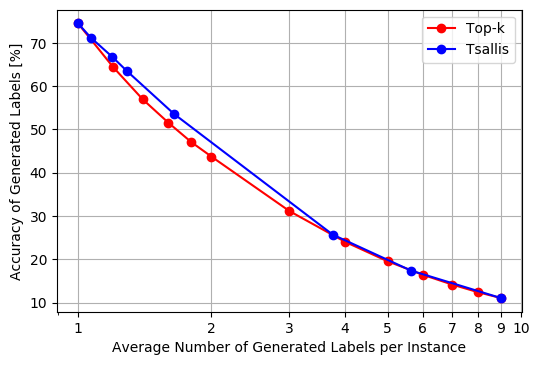

In [249]:
graph_it2(lacc, tsallis_lave, tsallis_lacc, 10)

0.2刻みでtop1から2の間を進み，その後はtop-2, top-3, ...

## merged into one graph

/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


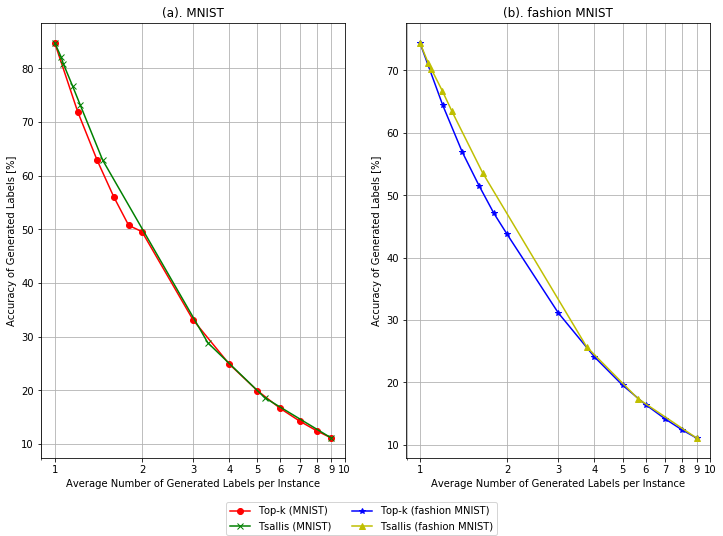

In [279]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
Rs = [1.0, 1.2, 1.4, 1.6, 1.8]
Rs.extend([i for i in range(2, 10)])

# for MNIST
topr_mnist = [84.8, 71.96666666666667, 62.93571428571429, 56.03125, 50.738888888888894, 49.57270833333334, 33.128650793650806, 24.887500000000006, 19.934380952380938, 16.60902777777778, 14.243968253968252, 12.463125, 11.094444444444445]
tsallis_lacc_mnist = [11.094444444444445, 18.58582054420488, 28.844444444444445, 62.90983606557377, 73.24346405228758, 76.71292281006072, 80.86794213719085, 82.20742150333017, 84.8]
tsallis_lnum_mnist = [9.0, 5.3105, 3.375, 1.464, 1.224, 1.153, 1.0715, 1.051, 1.0]

# for fashion MNIST
topr_fmnist = [74.45, 64.38333333333334, 56.921428571428564, 51.525, 47.09444444444445, 43.725, 31.15, 24.0875, 19.55, 16.45, 14.17142857142857, 12.41875, 11.083333333333334]
tsallis_lacc_fmnist = [74.45, 71.1214953271028, 70.24680073126143, 66.77838290741516, 63.42502905850446, 53.58444714459295, 25.69832402234637, 17.395538243626063, 11.083333333333334]
tsallis_lnum_fmnist = [1.0, 1.07, 1.094, 1.1935, 1.2905, 1.646, 3.759, 5.648, 9.0]

# Labels to use in the legend for each line
line_labels = ["Top-k (MNIST)", "Tsallis (MNIST)", "Top-k (fashion MNIST)", "Tsallis (fashion MNIST)"]

pos = [i + 1 for i in range(10)] 
ticks = [str(e) for e in pos]

# Create the sub-plots, assigning a different color for each line.
# Also store the line objects created
l1 = ax1.plot(Rs, topr_mnist, marker = 'o', color = 'r')
l2 = ax1.plot(tsallis_lnum_mnist[::-1], tsallis_lacc_mnist[::-1], marker = 'x', color = 'g')
# ax1 settings
ax1.set_xscale('log')
ax1.set_xticks(pos)
ax1.set_xticklabels(ticks)
ax1.grid(which = 'both')
ax1.set_xlabel("Average Number of Generated Labels per Instance")
ax1.set_ylabel("Accuracy of Generated Labels [%]")
ax1.title.set_text("(a). MNIST")

l3 = ax2.plot(Rs, topr_fmnist, marker = '*', color = 'b')
l4 = ax2.plot(tsallis_lnum_fmnist, tsallis_lacc_fmnist, marker = '^', color = 'y')
# ax2 settings
ax2.set_xscale('log')
ax2.set_xticks(pos)
ax2.set_xticklabels(ticks)
ax2.grid(which = 'both')
ax2.set_xlabel("Average Number of Generated Labels per Instance")
ax2.set_ylabel("Accuracy of Generated Labels [%]")
ax2.title.set_text("(b). fashion MNIST")

# Create the legend
fig.legend([l1, l2, l3, l4],     # The line objects
           labels = line_labels,   # The labels for each line
           loc = "lower center",   # Position of legend
           borderaxespad = 0.1,    # Small spacing around legend box
           ncol = 2)

# Adjust the scaling factor to fit your legend text completely outside the plot
# (smaller value results in more space being made for the legend)
plt.subplots_adjust(bottom = 0.125)
plt.savefig("final_exp.pdf")